# A demonstration of oslo_method_python


Before this notebook is run on a new system, make sure to compile the Cython files by doing (in the top repo directory):

```python setup.py build_ext --inplace```

In [1]:
%load_ext autoreload
import matplotlib.pyplot as plt
import numpy as np
import sys, os
sys.path.insert(0,"../")
import oslo_method_python as om
import copy
%autoreload 2
%matplotlib notebook

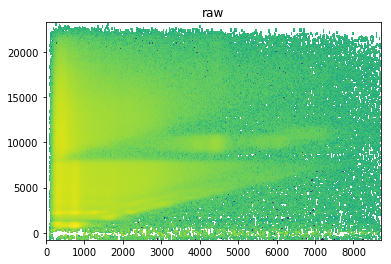

In [2]:
# Import raw matrix into instance of om.Matrix() and plot it
fname_raw = "../tests/Dy164_raw.m"
raw = om.Matrix()
raw.load(fname_raw)
raw.plot(title="raw")

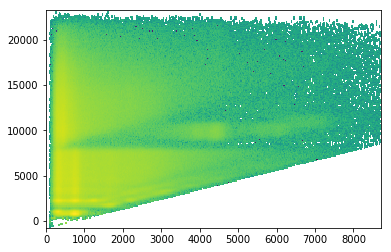

In [3]:
# Cut away diagonal
Ex1 = 0
Eg1 = 800
E1 = [Ex1, Eg1]
Ex2 = 8000
Eg2 = 8300
E2 = [Ex2, Eg2]
#raw_diagcut = copy.copy(raw)
#raw_diagcut.matrix = om.cut_diagonal(raw.matrix, raw.E0_array, raw.E1_array, E1, E2)
raw.cut_diagonal(E1, E2)
raw.plot()

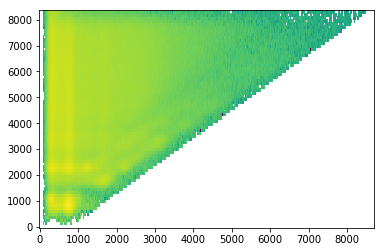

In [4]:
# Drop Ex larger than Sn, about 8300 keV
raw.cut_rect(axis=0, E_limits=[0, 8400])
raw.plot()

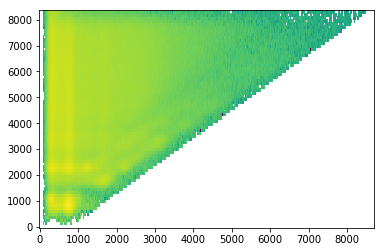

In [5]:
# Put it into an instance of om.MatrixAnalysis() to do unfolding and first generation method:
ma = om.MatrixAnalysis()
ma.raw = raw
ma.raw.plot()

Hello from the fill_negative() function. Please debug me.


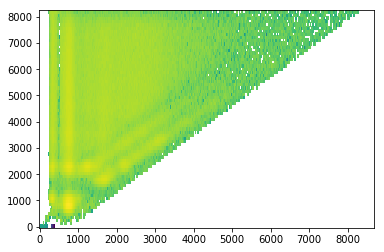

In [6]:
# Unfold the matrix. 
# I haven't implemented a fast enough routine for response function interpolation yet,
# so we have to load response functions with the right calibration, made by MAMA, from file.
fname_resp_mat = "../tests/Dy164_response_matrix.m"
fname_resp_dat = "../tests/Dy164_response_parameters.dat"

# Call the unfolding algorithm:
diag_cut = {"Ex1": 0, "Eg1": 800, "Ex2": 7300, "Eg2": 7500}
ma.unfold(fname_resp_dat=fname_resp_dat, fname_resp_mat=fname_resp_mat, diag_cut=diag_cut,
          fill_and_remove_negative=True)
# The result is stored in the Matrix() instance ma.unfolded. Plot it:
ma.unfolded.plot()

Hello from the fill_negative() function. Please debug me.


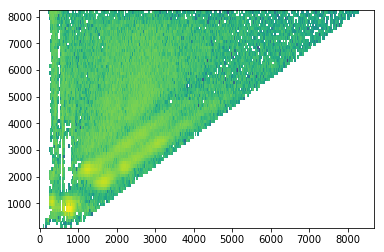

In [7]:
# Run first generation method
ma.first_generation_method(Ex_max = 8500, dE_gamma = 500,
                           fill_and_remove_negative=True)
ma.firstgen.plot(zmin=1e-3)

In [8]:
# Do error propagation in order to obtain an error matrix on the first generation spectrum
# Note that it requires an instance of MatrixAnalysis as input
ep = om.ErrorPropagation(ma, folder="error_propagation_ensemble", random_seed=481516)
ep.generate_ensemble(N_ensemble_members=10, randomness="poisson", purge_files=True)

=== Begin ensemble member  0  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  1  ===
Generating raw matrix
Unfolding matrix


../oslo_method_python/unfold.py:271: RuntimeWarning: invalid value encountered in true_divide
  fluctuations_matrix = fluctuations_matrix/fluctuations_vector_raw[:,None] # TODO check that this broadcasts the vector over the right dimension


Calculating first generation matrix
=== Begin ensemble member  2  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  3  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  4  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  5  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  6  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  7  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  8  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix
=== Begin ensemble member  9  ===
Generating raw matrix
Unfolding matrix
Calculating first generation matrix


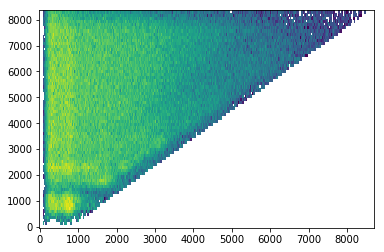

In [9]:
# Fetch and plot the standard deviation of raw:
std_raw = ep.std_raw
std_raw.plot()

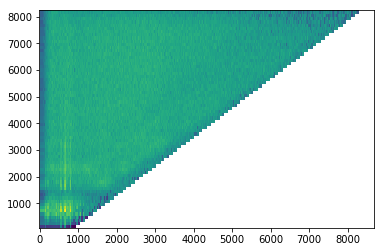

In [10]:
# Fetch and plot the standard deviation of firstgen:
std_firstgen = ep.std_firstgen
std_firstgen.plot()

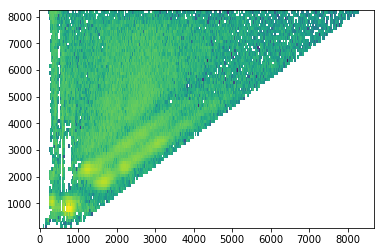

In [11]:
ma.firstgen.plot()

In [21]:
# Run fit to rho and T
# (This one needs some more bug testing...)

bin_width_out = 120
Ex_min = 3000
Ex_max = 8000
Eg_min = 1000

rho_ensemble = []
T_ensemble = []

this_mat = ma.firstgen.matrix
for i in range(len(ep.firstgen_ensemble)):
    print("Working on #{}".format(i))
    values = ep.firstgen_ensemble[i]
    fg_tmp = om.Matrix(values,ma.firstgen.E0_array,ma.firstgen.E1_array)
    fg_tmp.fill_negative(window_size=10)
    fg_tmp.remove_negative()
    fits = om.FitRhoT(fg_tmp, std_firstgen,
                      bin_width_out,
                      Ex_min, Ex_max, Eg_min,
                      method="Powell",
                      )
    rho = fits.rho
    T = fits.T
    
    rho_ensemble.append(rho.vector)
    T_ensemble.append(T.vector)

# attempting to create ensemble + uncertainties from the different fits
rho_ensemble = np.array(rho_ensemble)
rho_mean = np.mean(rho_ensemble,axis=0)
rho_std = np.std(rho_ensemble,axis=0)

T_ensemble = np.array(T_ensemble)
T_mean = np.mean(T_ensemble,axis=0)
T_std = np.std(T_ensemble,axis=0)

Working on #0
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 32803.433594
         Iterations: 7
         Function evaluations: 13572
Working on #1
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 32606.564453
         Iterations: 9
         Function evaluations: 17400
Working on #2
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 34685.078125
         Iterations: 9
         Function evaluations: 17956
Working on #3
Hello from the fill_negative() function. Please debug me.
attempt decomposition
Optimization terminated successfully.
         Current function value: 35863.132812
         Iterations: 9
         Function evaluations: 18317
Working on #4
Hello from the fill_negative() fun

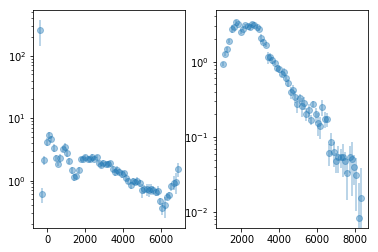

In [22]:
fig, (axrho, axT) = plt.subplots(1,2)
axrho.set_yscale("log")
axrho.errorbar(rho.E_array,rho_mean,yerr=rho_std,alpha=0.4, fmt="o")
#for i in range(10):
#    axrho.plot(range(len(rho.vector)),rho_ensemble[i,:],"-.")

axT.set_yscale("log")
axT.errorbar(T.E_array,T_mean,yerr=T_std, fmt="o", alpha=0.4)
#for i in range(10):
#    axT.plot(range(len(T.vector)),T_ensemble[i,:])

plt.show()

In [23]:
from uncertainties import unumpy
def normalize(P_in, P_err=None):
    ##############
    if P_err is None:
        norm = np.sum(P_in,axis=1)
        P_norm = P_in/norm[:,None]
        return P_norm
    else:
        u_oslo_matrix = unumpy.uarray(P_in, P_err)

        # normalize each Ex row to 1 (-> get decay probability)
        for i, normalization in enumerate(np.sum(u_oslo_matrix,axis=1)):
            try:
                u_oslo_matrix[i,:] /= normalization
            except ZeroDivisionError:
                u_oslo_matrix[i,:]=0
        P_in_norm = unumpy.nominal_values(u_oslo_matrix)
        P_err_norm = unumpy.std_devs(u_oslo_matrix)
        return P_in_norm, P_err_norm

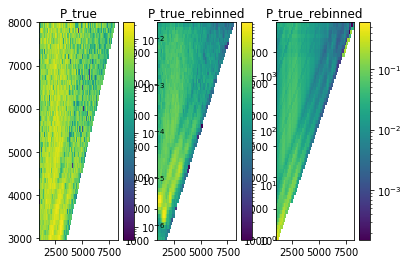

In [24]:
# Plot the experimental and fitted first-generation matrices:
# This plotting code is messy and should be cleaned up!
from matplotlib.colors import LogNorm

f2D, (ax_P_true, ax_P_true_rebinned, ax_P_fit) = plt.subplots(1, 3)

DE_MAX_RES = fits.dE_max_res
firstgen_cut = ma.firstgen.cut_rect(
                              axis="both",
                              E_limits=[Ex_min, Ex_max, Eg_min, Ex_max+DE_MAX_RES],
                              inplace=False
                              )
firstgen_cut.matrix = normalize(firstgen_cut.matrix)
cbar = ax_P_true.pcolormesh(firstgen_cut.E1_array,
                            firstgen_cut.E0_array,
                            firstgen_cut.matrix,
                            norm=LogNorm())
f2D.colorbar(cbar, ax=ax_P_true)
ax_P_true.set_title("P_true")

cbar = fits.firstgen.plot(ax=ax_P_true_rebinned)
ax_P_true_rebinned.set_title("P_true_rebinned")
f2D.colorbar(cbar, ax=ax_P_true_rebinned)

cbar = fits.Pfit.plot(ax=ax_P_fit)
ax_P_fit.set_title("P_true_rebinned")
f2D.colorbar(cbar, ax=ax_P_fit)

plt.show()

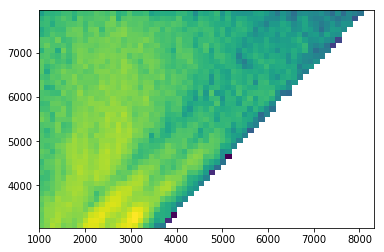

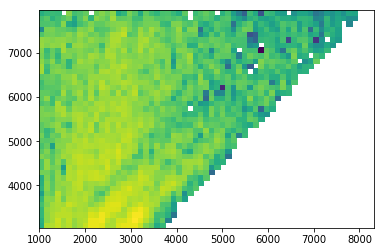

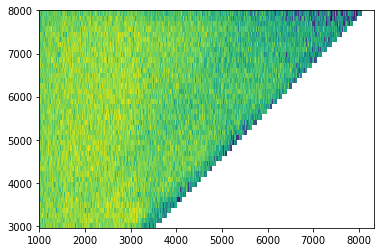

In [25]:
# Something's strange about the interpolations of the STDDev:
# -- Somehow some standard deviations go to 0? (-> Holes in the matrix)

fg_fit = copy.deepcopy(fits.firstgen)
fg_fit = fg_fit.cut_rect(
                              axis="both",
                              E_limits=[Ex_min, Ex_max, Eg_min, Ex_max+DE_MAX_RES],
                              inplace=False
                              )

fg_fit.plot()

fgstd_fit = copy.deepcopy(fits.firstgen_std)
fgstd_fit = fgstd_fit.cut_rect(
                              axis="both",
                              E_limits=[Ex_min, Ex_max, Eg_min, Ex_max+DE_MAX_RES],
                              inplace=False
                              )

fgstd_fit.plot()

std_firstgen_cut = copy.deepcopy(std_firstgen)
std_firstgen_cut = std_firstgen_cut.cut_rect(
                              axis="both",
                              E_limits=[Ex_min, Ex_max, Eg_min, Ex_max+DE_MAX_RES],
                              inplace=False
                              )

std_firstgen_cut.plot()

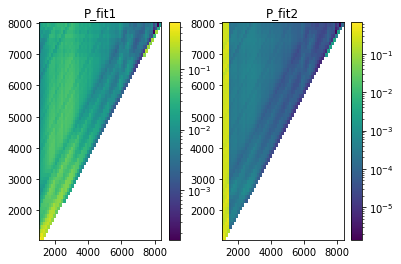

True

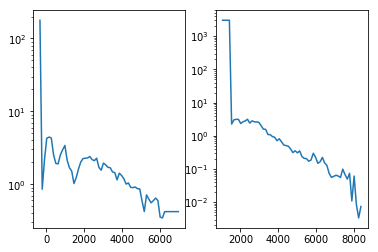

In [26]:
# just some weird tests
fig, (ax1,ax2) = plt.subplots(1,2)
fits.Emid_nld = rho.E_array + bin_width_out/2


r_edit = copy.deepcopy(rho)
T_edit = copy.deepcopy(fits.T)

Emid_Ex = fits.Pfit.E0_array + bin_width_out/2
Emid_Eg = fits.Pfit.E1_array + bin_width_out/2
Emid_nld = rho.E_array + bin_width_out/2

P_fit1 = om.PfromRhoT(r_edit.vector, T_edit.vector, len(Emid_Ex),
                     Emid_Eg, Emid_nld, Emid_Ex, fits.dE_resolution)

r_edit.vector[-6:]=r_edit.vector[-7]
T_edit.vector[:4]=T_edit.vector[5]*1e3

P_fit2 = om.PfromRhoT(r_edit.vector, T_edit.vector, len(Emid_Ex),
                     Emid_Eg, Emid_nld, Emid_Ex, fits.dE_resolution)


cbar1 = ax1.pcolormesh(Emid_Eg, Emid_Ex, P_fit1, norm=LogNorm())
ax1.set_title("P_fit1")
cbar2 = ax2.pcolormesh(Emid_Eg, Emid_Ex, P_fit2, norm=LogNorm())
ax2.set_title("P_fit2")
fig.colorbar(cbar1, ax=ax1)
fig.colorbar(cbar2, ax=ax2)
plt.show()

f, (axrho, axT) = plt.subplots(1,2)
r_edit.plot(ax=axrho, yscale="log")
T_edit.plot(ax=axT, yscale="log")

# TODO: Add "does it work" plots...
(comparing P_true and P_fit, both normalized to unity, for single Ex bins as 1-D plots)